In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import constants as const
from phidl import quickplot as qp
from phidl import Device
from phidl import CrossSection
from phidl import Path
import phidl.geometry as pg
import phidl.routing as pr
import phidl.path as pp
import pprint

In [2]:
from pathlib import Path
import sys
sys.path.append(str(Path.cwd() / 'util/'))
import qubit_templates
from qubit_templates import *
from functions import *

# Read configuration file

In [3]:
feedline_resonator_gap = 13 
n_gridline = 20
JJtype = "mh" # mh or dl (manhattan or dolan)
Bandage = False
DCLine = True # Add DC line next to squids
Entangle = True # Connect two transmons
SimulationDesign = False # Make inverted design for HFSS simulation (This takes a long time...)

outname = "waferdesign_2D_" + JJtype
if Bandage:
    outname += "bd"
if DCLine:
    outname += "_dcline"
if Entangle:
    outname += "_entangle"    


config = load_config( f"config/common.yaml" )
# グローバル変数として定義
globals().update(config)
qubit_templates.__dict__.update(config)

# Wafer design

In [4]:
wafer = device_Wafer(inch = 4)

# Chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


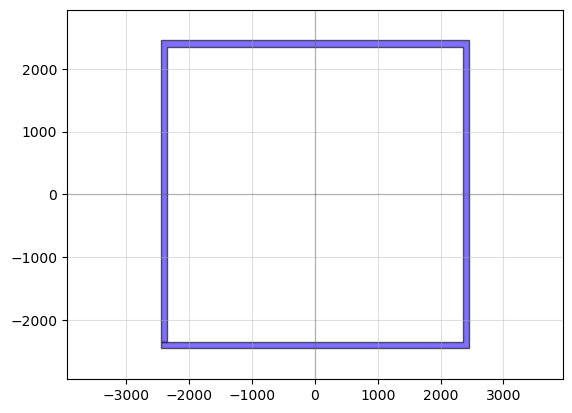

In [5]:
chipdesign = Device('chipdesign')

FM=Device('frame')
rectangle = pg.rectangle((Frame_size_width, Frame_size_height), Frame_layer)
FM.add_ref( pg.invert(rectangle, border = Frame_width, precision = 1e-6, layer = Frame_layer) )
FM.center = (0, 0)

chipdesign.add_ref(FM)
# Quickplot the imported design
qp(chipdesign)

# Launch pad

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


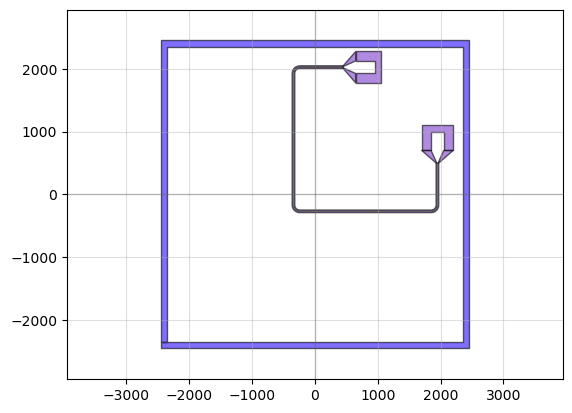

In [6]:
FL = device_FeedLine()
chipdesign.add_ref(FL)
qp(chipdesign)


# Corner points

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


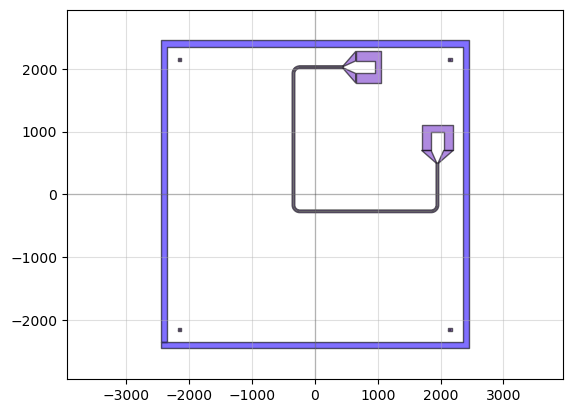

In [7]:
CP = device_CornerPoints()
chipdesign.add_ref(CP)
qp(chipdesign)

# Test Areas

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


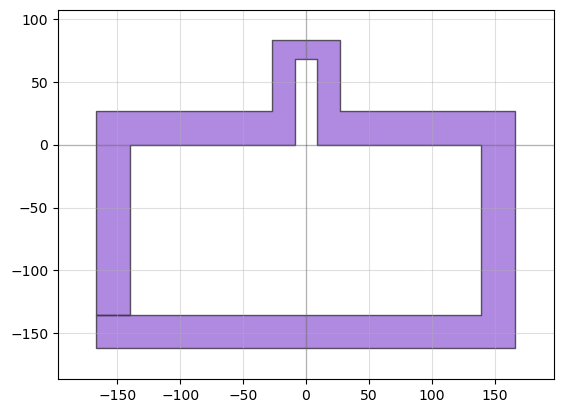

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


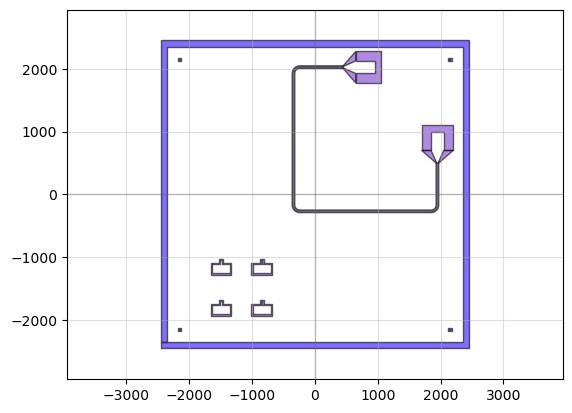

In [8]:
TA = device_TestAreas(DCLine = DCLine)
chipdesign.add_ref(TA)
qp(chipdesign)

# Resonator

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


Length : 3935.2841353212234 [um]
Length : 4045.2841353212234 [um]
Length : 4323.093481820941 [um]
Length : 4183.093481820941 [um]


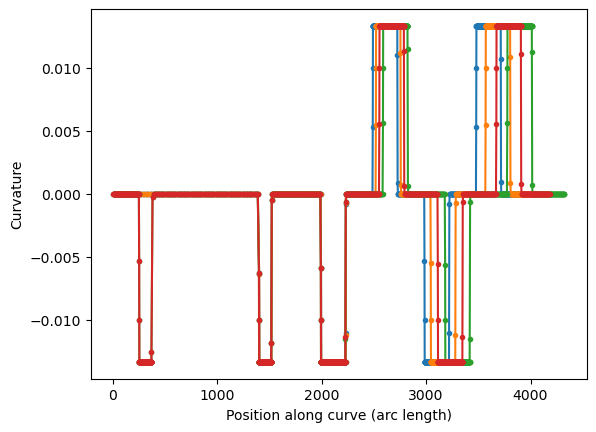

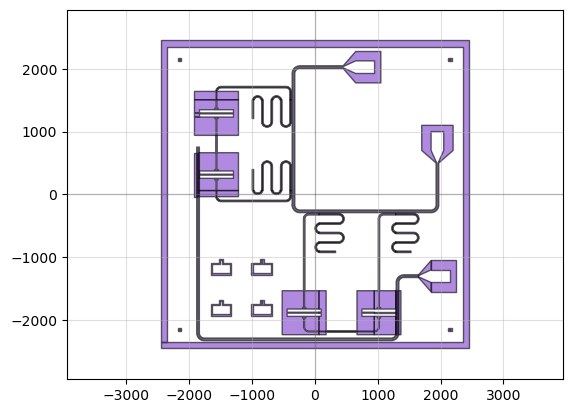

In [9]:
R1_tmp = device_Resonator(resonator_straight1 = 220, resonator_straight2 = 260, resonator_straight3 = 475, resonator_straight4 = 1400, entangle = Entangle)
R1_tmp.movex(1315)
R1_tmp.ymax = FL.ymin - feedline_resonator_gap
R1 = pg.copy_layer(R1_tmp, 4, 4)
chipdesign.add_ref(R1)

R2_tmp = device_Resonator(resonator_straight1 = 240, resonator_straight2 = 290, resonator_straight3 = 475, resonator_straight4 = 1400, entangle = Entangle)
R2_tmp.movex(145)
R2_tmp.ymax = FL.ymin - feedline_resonator_gap
R2 = pg.copy_layer(R2_tmp, 4, 4)
chipdesign.add_ref(R2)

if Entangle:
    R3_tmp = device_Resonator(resonator_straight1 = 310, resonator_straight2 = 360, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, mirror = True, entangle = Entangle)
else:
    R3_tmp = device_Resonator(resonator_straight1 = 310, resonator_straight2 = 360, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, mirror = False, entangle = Entangle)
R3_tmp.movey(408)
R3_tmp.xmax = FL.xmin - feedline_resonator_gap
R3 = pg.copy_layer(R3_tmp, 4, 4)
chipdesign.add_ref(R3)

R4_tmp = device_Resonator(resonator_straight1 = 275, resonator_straight2 = 325, resonator_straight3 = 475, resonator_straight4 = 1030, side = True, entangle = Entangle)
R4_tmp.movey(1383)
R4_tmp.xmax = FL.xmin - feedline_resonator_gap
R4 = pg.copy_layer(R4_tmp, 4, 4)
chipdesign.add_ref(R4)

if Entangle:
    # Line_1to2 = Device("Line1to2")
    # Line_3to4 = Device("Line3to4")

    X = CrossSection()
    line_width = 10
    line_gap_width = 6
    X.add(width= line_width, offset = 0, layer = 1)
    X.add(width= line_gap_width, offset = 0.5*(line_width + line_gap_width), layer = 4)
    X.add(width= line_gap_width, offset = -0.5*(line_width + line_gap_width), layer = 4)

    line_1to2 = pr.route_smooth(
        port1 = R1_tmp.references[0].ports['entangle'],
        port2 = R2_tmp.references[0].ports['entangle'],
        width = X,
        radius = 75,
        path_type = 'U',
        length1 = 120 + 75,
        smooth_options=  {'corner_fun': pp.arc}
        )
    
    line_3to4 = pr.route_smooth(
        port1 = R3_tmp.references[0].ports['entangle'],
        port2 = R4_tmp.references[0].ports['entangle'],
        width = X,
        path_type = 'straight')    

    chipdesign = pg.boolean(chipdesign, pg.copy_layer(line_1to2, 1, 4), 'not', layer = 4)
    chipdesign = pg.boolean(chipdesign, pg.copy_layer(line_3to4, 1, 4), 'not', layer = 4)
    chipdesign.add_ref( pg.copy_layer(line_1to2, 4, 4) )
    chipdesign.add_ref( pg.copy_layer(line_3to4, 4, 4) )


if DCLine:
    DC_tmp = device_DCLine()
    DC = pg.copy_layer(DC_tmp, 4, 4)
    DC_subtract = pg.copy_layer(DC_tmp, 1, 1)
    chipdesign = pg.boolean(chipdesign, DC_subtract, 'not', layer = 4)
    chipdesign.add_ref(DC)

chipdesign.write_gds('output/dcline.gds')
qp(chipdesign)

In [10]:
if SimulationDesign:
    # Produce inverted version for simulation
    chipdesign_inverted = Device('chipdesign_inverted')
    chipdesign_inverted_FL = Device('chipdesign_inverted_FL')
    chipdesign_inverted_FL_DoubleRes = Device('chipdesign_inverted_FL_DoubleRes')
    chipdesign_inverted.add_ref(FL)
    chipdesign_inverted_FL.add_ref(FL)
    chipdesign_inverted_FL_DoubleRes.add_ref(FL)
    chipdesign_inverted_FL_DoubleRes.add_ref(R1_tmp)
    chipdesign_inverted_FL_DoubleRes.add_ref(R4_tmp)
    chipdesign_inverted.add_ref(R1_tmp)
    chipdesign_inverted.add_ref(R2_tmp)
    chipdesign_inverted.add_ref(R3_tmp)
    chipdesign_inverted.add_ref(R4_tmp)
    # chipdesign_inverted.add_ref(CP)
    # chipdesign_inverted.add_ref(TA)
    if DCLine:
        chipdesign_inverted.add_ref(DC_tmp)
    if Entangle:
        chipdesign_inverted.add_ref(line_1to2)
        chipdesign_inverted.add_ref(line_3to4)

    rectangle = pg.bbox([(-2400, -2400),(2400, 2400)], 0)
    trace_DoubleRes = pg.copy_layer(chipdesign_inverted_FL_DoubleRes, 1, 4)
    trace = pg.copy_layer(chipdesign_inverted, 1, 4)
    chipdesign_inverted = pg.boolean(rectangle, chipdesign_inverted, operation = 'not', layer = 4)
    chipdesign_inverted_FL = pg.boolean(rectangle, chipdesign_inverted_FL, operation = 'not', layer = 4)
    chipdesign_inverted_FL_DoubleRes = pg.boolean(rectangle, chipdesign_inverted_FL_DoubleRes, operation = 'not', layer = 4)

    chipdesign_inverted_FL_DoubleRes.add_ref(trace_DoubleRes)
    chipdesign_inverted.add_ref(trace)

    qp(chipdesign_inverted)
    qp(chipdesign_inverted_FL)
    qp(chipdesign_inverted_FL_DoubleRes)

    chipdesign_inverted.write_gds('output/chipdesign_simulation.gds')
    chipdesign_inverted_FL.write_gds('output/chipdesign_onlyFL_simulation.gds')
    chipdesign_inverted_FL_DoubleRes.write_gds('output/chipdesign_onlyFL_DoubleRes_simulation.gds')

# Josephson Junction

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


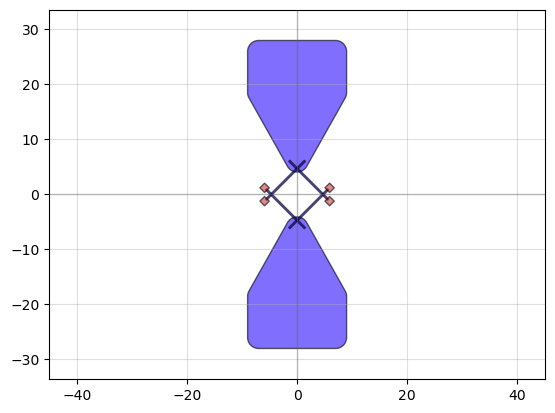

In [11]:
JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = True, bandage = False)
# JJ = device_JJ(width = 0.3, JJtype = "manhattan", squid = False, bandage = False)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = True, bandage = True)
# JJ = device_JJ(width = 0.135, JJtype = "manhattan", squid = False, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = False)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = True, bandage = True)
# JJ = device_JJ(width = 1.0, JJtype = "dolan", squid = False, bandage = True)
qp(JJ)


# Add test boxes for EB

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


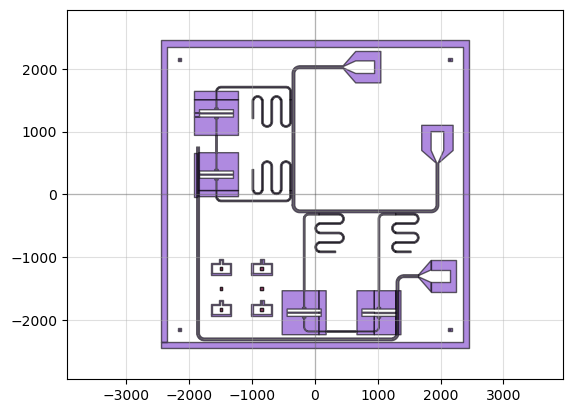

In [12]:
BX = device_TestBoxes(DCLine = DCLine)
chipdesign.add_ref(BX)
qp(chipdesign)

# Add JJ to chip design

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


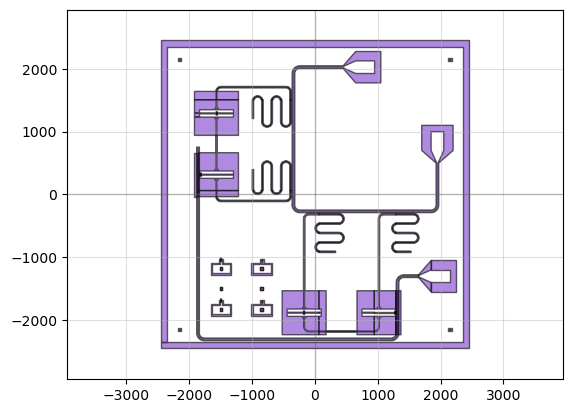

'output/chipdesign.gds'

In [13]:
def custom_chip(width, height):
    chip = Device('chip')
    chip.add_ref(chipdesign)

    JJ_trans = device_JJ(width = width, JJtype = JJtype, squid = False, bandage = Bandage)
    JJ_squid = device_JJ(width = width, JJtype = JJtype, squid = True , bandage = Bandage)
    EBLine = device_EBLine()

    # SQUID
    chip.add_ref(JJ_squid).movex(1280).movey(-1880)
    # transmon
    chip.add_ref(JJ_trans).movex(-172).movey(-1880)
    # SQUID
    chip.add_ref(JJ_squid).movex(-1815).movey(315)    
    # transmon
    chip.add_ref(JJ_trans).movex(-1560).movey(1290)

    # transmon (test)
    if DCLine:
        chip.add_ref(JJ_trans).movex(-1493).movey(-1689)
        chip.add_ref(JJ_trans).movex(-1493).movey(-1038)
        chip.add_ref(EBLine).movex(-843).movey(-1689)
        chip.add_ref(EBLine).movex(-843).movey(-1038)
    else:
        chip.add_ref(JJ_trans).movex(-1743).movey(-1739)
        chip.add_ref(JJ_trans).movex(-1743).movey(-1088)
        chip.add_ref(EBLine).movex(-1093).movey(-1739)
        chip.add_ref(EBLine).movex(-1093).movey(-1088)    

    return chip

chip = custom_chip(width = 0.135, height = None)
qp(chip)
chip.write_gds('output/chipdesign')

# Place chip designs

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


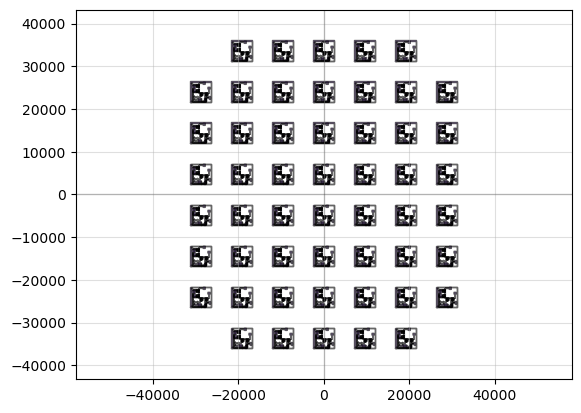

In [14]:


D = pg.gridsweep(
    function = custom_chip,
    param_x = {'width' :  Grid_width},
    param_y = {'height' : Grid_height},
    spacing = (Grid_gap_x * Frame_size_width, Grid_gap_y * Frame_size_height),
    label_layer = None
    )
D.center = (0,0)

## Remove corners
for iref, ref in enumerate(D.references[:]):
    if iref == 0 or iref == len(Grid_width)-1 or iref == len(Grid_width) * (len(Grid_height)-1) or iref == len(Grid_width) * len(Grid_height) - 1:
        D.remove(ref)

wafer.add_ref(D)
qp(D)


# Add EB markers

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


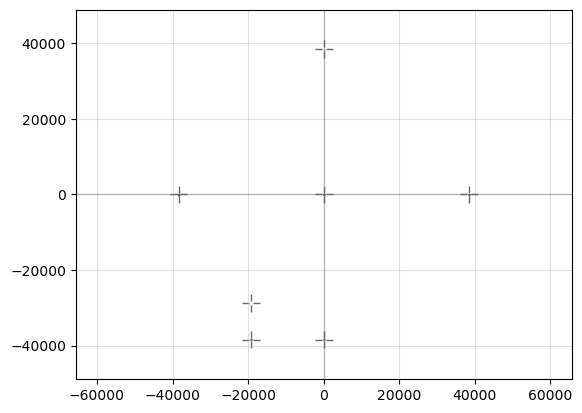

DeviceReference (parent Device "EBmarkers", ports [], origin (0, 0), rotation 0, x_reflection False)

In [15]:
EBmarkers = device_EBmarkers(marker_pos = EBMarker_pos, layer = EBMarker_layer)
qp(EBmarkers)
wafer.add_ref(EBmarkers)


# Add grid lines

Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


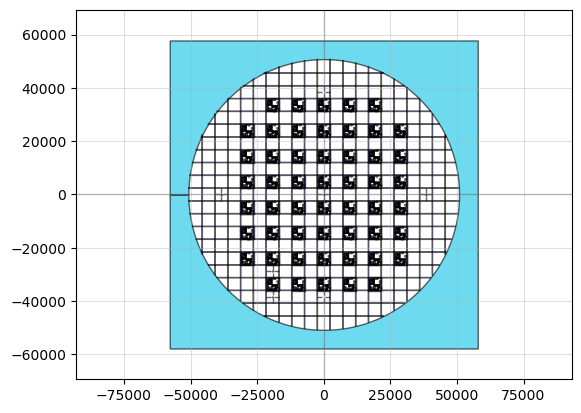

In [16]:
grid = device_Grid(inch = 4, n_gridline = n_gridline)
wafer.add_ref( grid )

qp(wafer)


In [17]:
wafer.write_gds('output/' + outname)

'output/waferdesign_2D_mh_dcline_entangle.gds'